In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy import units as u
from astropy import constants as const
from astropy.wcs import WCS
from scipy import ndimage
import radio_beam
from spectral_cube import SpectralCube
from reproject import reproject_exact
import matplotlib.pyplot as plt
from time import localtime, strftime#, time
#import os.path
#import glob
#from pyBBarolo.wrapper import BBaroloWrapper

In [2]:
califaoutpath = '/vol/aibn1081/data1/brodriguez/CALIFA/'
acaoutpath    = '/vol/aibn1081/data1/brodriguez/ACA/'
califainpath  = '/vol/alcina/data1/shared/EDGE/PIPE3DS_v2.3/'
acainpath     = '/vol/alcina/data1/shared/EDGE/aca_edge_natv/cubes/'

In [3]:
califapattern = os.path.join(califainpath,"*.Pipe3D.cube.fits.gz")
acapattern = os.path.join(acainpath,"*_7m_co21_pbcor.fits")
print("CALIFA input pattern:",califapattern)
print("ACA input pattern:",acapattern)
califafilepaths = sorted(glob.glob(califapattern))
acafilepaths = sorted(glob.glob(acapattern))

CALIFA input pattern: /vol/alcina/data1/shared/EDGE/PIPE3DS_v2.3/*.Pipe3D.cube.fits.gz
ACA input pattern: /vol/alcina/data1/shared/EDGE/aca_edge_natv/cubes/*_7m_co21_pbcor.fits


In [4]:
califa_sources = np.array([filename.replace('.Pipe3D.cube.fits.gz','').replace(califainpath,'') for filename in califafilepaths])
aca_sources = np.array([filename.replace('_7m_co21_pbcor.fits','').replace(acainpath,'') for filename in acafilepaths])
sources = aca_sources[np.isin(aca_sources,califa_sources)]

In [5]:
print ("Number of CALIFA files found : ",len(califafilepaths))
print ("Number of ACA cubes found : ",len(acafilepaths))
print ("Number of overlapping sources : ",len(sources))

Number of CALIFA files found :  895
Number of ACA cubes found :  60
Number of overlapping sources :  55


In [16]:
aca_table = pd.read_csv('/users/brodriguez/Documents/ACA_sourcelist.csv',sep=',',index_col=0)

In [17]:
aca_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, CGCG429-012 to VV488NED02
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   califa_file  60 non-null     object 
 1   Final_QS     60 non-null     object 
 2   Final_NA     60 non-null     object 
 3   RA           60 non-null     float64
 4   DEC          60 non-null     float64
 5   i            60 non-null     int64  
 6   PA           60 non-null     int64  
 7   z            60 non-null     float64
dtypes: float64(3), int64(2), object(3)
memory usage: 4.2+ KB


In [18]:
sources = aca_table[aca_table['califa_file']!='---'].index.to_numpy()

In [20]:
aca_table = aca_table.loc[sources]

In [21]:
califa_table = pd.read_csv('/users/brodriguez/Documents/get_proc_elines_CALIFA_2022.csv',sep=',',skiprows=587,index_col=0,
                    usecols=['name','z_stars','log_Mass','log_SFR_SF','Re_arc','Re_kpc','Inclination','P.A.'])#'log_Mass_no_corr','log_Mass_corr','lSFR','z_gas','log_SFR_ssp','DL','DA','P.A.','log_Mass_gas','log_Mass_gas_Re'])
califa_table = califa_table.loc[sources]

In [22]:
print(len(aca_table),len(califa_table))

58 58


In [8]:
n = 0
for source in sources:
    hdu_list = fits.open(califainpath+source+'.Pipe3D.cube.fits.gz')
    n+=1
    hdu_list.close()
print(n)

55


In [16]:
hdu_list = fits.open(califainpath+'UGC12250'+'.Pipe3D.cube.fits.gz')

In [20]:
WCS(hdu_list[0].header).to_header()

WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =                 69.0 / Pixel coordinate of reference point            
CRPIX2  =                 63.0 / Pixel coordinate of reference point            
CRPIX3  =                  1.0 / Pixel coordinate of reference point            
PC1_1   = -0.00013888888888888 / Coordinate transformation matrix element       
PC2_2   =  0.00013888888888889 / Coordinate transformation matrix element       
PC3_3   =                  2.0 / Coordinate transformation matrix element       
CDELT1  =                  1.0 / [deg] Coordinate increment at reference point  
CDELT2  =                  1.0 / [deg] Coordinate increment at reference point  
CDELT3  =                  1.0 / [Angstrom] Coordinate increment at reference po
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CUNIT3  = 'Angstrom'        

outputpath = '/vol/aibn1081/data1/brodriguez/'
califapath = '/vol/alcina/data1/shared/EDGE/PIPE3DS_v2.3/'
acapath = '/vol/alcina/data1/shared/EDGE/aca_edge_natv/cubes/'

path = '/vol/aibn1081/data1/brodriguez/'
source = 'UGC12250'
cube_path = path+source+'_7m_co21_pbcor.fits'
reduced_path = cube_path.replace('pbcor','reduced')
mask_path = cube_path.replace('pbcor','smoothmask')
integrated_path = cube_path.replace('pbcor','integrated')

In [29]:
for source in sources[3:55]:
    cube_path = acainpath+source+'_7m_co21_pbcor.fits'
    reduced_path    = acaoutpath+source+'_reduced.fits'
    mask_path       = acaoutpath+source+'_smoothmask.fits'
    integrated_path = acaoutpath+source+'_integrated.fits'

    CO_cube = SpectralCube.read(cube_path)
    CO_cube = CO_cube.minimal_subcube()
    if CO_cube.unit == 'Jy/beam':
        CO_cube = CO_cube.to(u.K)
    if CO_cube.header['CUNIT3'] == 'm/s':
        CO_cube = CO_cube.with_spectral_unit(u.km/u.s)
    CO_cube.write(reduced_path, format='fits',overwrite=True)
    hdu = fits.open(reduced_path)
    data = hdu[0].data
    header = hdu[0].header
    del header['TIMESYS']# = 'utc'
    hdu.close()
    fits.writeto(reduced_path,data,header,overwrite=True)

    # convolving cube to larger resolution for creation of smoothed mask
    beam_6 = radio_beam.Beam(major=6*u.arcsec, minor=6*u.arcsec, pa=0*u.deg)
    beam_9 = radio_beam.Beam(major=9*u.arcsec, minor=9*u.arcsec, pa=0*u.deg)
    CO_cube_smooth = CO_cube.with_beam(beam_6)
    CO_cube_smooth = CO_cube_smooth.convolve_to(beam_9)
    # creating RMS map using free_channels ON EITHER SIDE of the cube:
    free_channels = 10
    CO_RMS_smooth = np.concatenate((CO_cube_smooth.unmasked_data[:free_channels,:,:].value,CO_cube_smooth.unmasked_data[-free_channels:,:,:].value))
    CO_RMS_smooth = np.sqrt(np.mean(np.square(CO_RMS_smooth),axis=0))
    # creating SNR cube:
    SNR_cube_smooth = CO_cube_smooth.unmasked_data[:].value
    SNR_cube_smooth = SNR_cube_smooth/np.broadcast_to(CO_RMS_smooth,SNR_cube_smooth.shape)
    # finding regions of low and high SNR:
    high_SNR_mask_smooth = SNR_cube_smooth>4 # 3.5
    low_SNR_mask_smooth = SNR_cube_smooth>2
    labeled_mask_high_smooth, num_high = ndimage.label(high_SNR_mask_smooth)
    print("Number of high SNR features found: ",num_high)
    labeled_mask_low_smooth, num_low = ndimage.label(low_SNR_mask_smooth)
    print("Number of low SNR features found: ",num_low)
    # ensuring high SNR regions span at least 2 adjacent channels:
    for i, region in enumerate(ndimage.find_objects(labeled_mask_high_smooth)):
        probe = np.where(labeled_mask_high_smooth[region]==i+1,high_SNR_mask_smooth[region],0)
        if (np.sum(probe,axis=0)<2).all():
            high_SNR_mask_smooth[labeled_mask_high_smooth==i+1] = 0
    labeled_mask_high_smooth, num_high = ndimage.label(high_SNR_mask_smooth)
    print("Number of high SNR features left: ",num_high)
    # creating smooth mask from dilated regions of high SNR:
    smooth_mask = np.isin(labeled_mask_low_smooth,labeled_mask_low_smooth[high_SNR_mask_smooth])
    smooth_mask = ndimage.binary_dilation(smooth_mask,iterations=2)
    # requiring non-negative fluxes in unmasked pixels:
    smooth_mask = np.where((CO_cube.unmasked_data[:].value>=0)&np.isfinite(CO_cube.unmasked_data[:].value),smooth_mask,0)
    # saving mask as fits file with WCS in header:
    mask_header = WCS(CO_cube.header).to_header()
    mask_header['OBJECT'] = source
    mask_header['TELESCOP'] = 'ALMA'
    fits.writeto(mask_path,data=smooth_mask&1,header=mask_header,overwrite=True)

    # using smooth mask to generate 0th moment map (integrated intensity)
    CO_cube_masked_smooth = CO_cube.with_mask(smooth_mask)
    mom0_smooth = CO_cube_masked_smooth.moment(order=0)
    # saving integrated intensity map as fits file with corresponding header:
    fits.writeto(integrated_path,data=mom0_smooth.value,header=mom0_smooth.header,overwrite=True)

    # defining pyBBarolo instance with reduced cube and smoothed mask, requesting velocity and velocity dispersion maps
    bb = BBaroloWrapper(fitsfile=reduced_path,mask='file('+mask_path+')',dispersionmap=True,velocitymap=True,outfolder=acaoutpath,verbose=False)
    bb.run()
    print('Finished creating ACA files for source ',source)

Number of high SNR features found:  217
Number of low SNR features found:  2542
Number of high SNR features left:  14

=====                                                           =====
=====                   Welcome to BBarolo v1.7                 =====
=====                                                           =====


-------------------------- Parameters -------------------------

FITS file to be analysed..........................[FITSFILE]  =  /vol/aibn1081/data1/brodriguez/ACA/CGCG429-012reduced.fits
Number of threads..................................[THREADS]  =  64
Producing output plots?..............................[PLOTS]  =  true
Showing progress bars?.............................[SHOWBAR]  =  true
Printing output messages?..........................[VERBOSE]  =  true
Directory where outputs are written..............[OUTFOLDER]  =  /vol/aibn1081/data1/brodriguez/ACA/
Redirect output messages to a file?................[LOGFILE]  =  false
Using robust statistics?......

Number of high SNR features found:  74
Number of low SNR features found:  1648
Number of high SNR features left:  5

=====                                                           =====
=====                   Welcome to BBarolo v1.7                 =====
=====                                                           =====


-------------------------- Parameters -------------------------

FITS file to be analysed..........................[FITSFILE]  =  /vol/aibn1081/data1/brodriguez/ACA/IC1079reduced.fits
Number of threads..................................[THREADS]  =  64
Producing output plots?..............................[PLOTS]  =  true
Showing progress bars?.............................[SHOWBAR]  =  true
Printing output messages?..........................[VERBOSE]  =  true
Directory where outputs are written..............[OUTFOLDER]  =  /vol/aibn1081/data1/brodriguez/ACA/
Redirect output messages to a file?................[LOGFILE]  =  false
Using robust statistics?.............

Number of high SNR features found:  103
Number of low SNR features found:  2076
Number of high SNR features left:  5

=====                                                           =====
=====                   Welcome to BBarolo v1.7                 =====
=====                                                           =====


-------------------------- Parameters -------------------------

FITS file to be analysed..........................[FITSFILE]  =  /vol/aibn1081/data1/brodriguez/ACA/IC1528reduced.fits
Number of threads..................................[THREADS]  =  64
Producing output plots?..............................[PLOTS]  =  true
Showing progress bars?.............................[SHOWBAR]  =  true
Printing output messages?..........................[VERBOSE]  =  true
Directory where outputs are written..............[OUTFOLDER]  =  /vol/aibn1081/data1/brodriguez/ACA/
Redirect output messages to a file?................[LOGFILE]  =  false
Using robust statistics?............

In [ ]:
print(sources)

In [7]:
for source in sources[3:55]:
    hdu_list = fits.open(califainpath+source+'.Pipe3D.cube.fits.gz')
    califa_hdr = WCS(hdu_list[0].header).celestial.to_header()
    califa_hdr['OBJECT'] = source
    califa_hdr['INSTRUME'] = 'PPAK'
    califa_hdr['BMAJ'] = 2.5#/3600
    califa_hdr['BMIN'] = 2.5#/3600
    
    califa_hdr3D = WCS(hdu_list[0].header).to_header()
    califa_hdr3D['CRPIX3']=0
    califa_hdr3D['CTYPE3']='VRAD'
    califa_hdr3D['CUNIT3']='m/s'
    
    # fluxes in 10^-16 erg s^-1 cm^-2
    F_NII = hdu_list[5].data[46]
    F_OIII = hdu_list[5].data[26]
    F_Ha = hdu_list[5].data[45]
    F_Hb = hdu_list[5].data[28]
    eF_NII = hdu_list[5].data[262]
    eF_OIII = hdu_list[5].data[242]
    eF_Ha = hdu_list[5].data[261]
    eF_Hb = hdu_list[5].data[244]
    # Equivalent Width in Angstrom
    EW_Ha = -hdu_list[5].data[207] # emission line EW defined as negative
    eEW_Ha = hdu_list[5].data[423]
    # obtaining stellar mass by correcting with dezonification zone
    M_star = np.power(10,hdu_list[1].data[19])*hdu_list[1].data[2]
    eM_star = np.power(10,hdu_list[1].data[20])*hdu_list[1].data[2]
    
    # 2D masks
    gaia = hdu_list[7].data # bright star mask
    region = hdu_list[8].data # valid region mask
    hdu_list.close()
    region = region&np.where(gaia!=0,0,1)
    for frame in [F_Ha,F_Hb,F_OIII,F_NII,EW_Ha,M_star,
                  eF_Ha,eF_Hb,eF_OIII,eF_NII,eEW_Ha,eM_star]:
        frame[region<1] = np.nan
    # creating mask according to Ha_EW>6A and Ha_EW S/N>1
    Ha_mask = (EW_Ha/eEW_Ha>1)&(EW_Ha>6)
    
    # saving masks
    fits.writeto(califaoutpath+source+'_region.fits',region&1,califa_hdr3D,overwrite=True)
    fits.writeto(califaoutpath+source+'_Ha_mask.fits',Ha_mask&1,califa_hdr,overwrite=True)
    # saving stellar mass map and uncertainty
    califa_hdr.set('BUNIT','M_sun')
    fits.writeto(califaoutpath+source+'_Mstar.fits', M_star,califa_hdr,overwrite=True)
    fits.writeto(califaoutpath+source+'_eMstar.fits',eM_star,califa_hdr,overwrite=True)
    # saving flux maps and uncertainties
    califa_hdr.set('BUNIT','10^-16 erg s^-1 cm^-2')    
    fits.writeto(califaoutpath+source+'_F_NII.fits', F_NII, califa_hdr,overwrite=True)
    fits.writeto(califaoutpath+source+'_F_OIII.fits',F_OIII,califa_hdr,overwrite=True)
    fits.writeto(califaoutpath+source+'_F_Ha.fits',  F_Ha,  califa_hdr,overwrite=True)
    fits.writeto(califaoutpath+source+'_F_Hb.fits',  F_Hb,  califa_hdr,overwrite=True)    
    fits.writeto(califaoutpath+source+'_eF_NII.fits', eF_NII, califa_hdr,overwrite=True)
    fits.writeto(califaoutpath+source+'_eF_OIII.fits',eF_OIII,califa_hdr,overwrite=True)
    fits.writeto(califaoutpath+source+'_eF_Ha.fits',  eF_Ha,  califa_hdr,overwrite=True)
    fits.writeto(califaoutpath+source+'_eF_Hb.fits',  eF_Hb,  califa_hdr,overwrite=True)
    print('Finished creating CALIFA files for source ',source)

Finished creating CALIFA files for source  CGCG429-012
Finished creating CALIFA files for source  IC1079
Finished creating CALIFA files for source  IC1528


In [23]:
from astropy.cosmology import LambdaCDM#, FlatLambdaCDM
cosmo = LambdaCDM(H0=69.7,Om0=0.3,Ode0=0.7)

In [24]:
def get_data(filename,header=False):
    hdu_list = fits.open(filename)
    data = hdu_list[0].data
    hdr = hdu_list[0].header
    hdu_list.close()
    if header:
        return data, hdr
    else:
        return data

In [39]:
def deproject(ra, dec, galpos, vector = False,
              gal=None):

    np.seterr(divide='ignore', invalid='ignore')
    #print(ra.shape,dec.shape)

    if not gal is None:
        pa = np.deg2rad(gal["posang_deg"])
        inc = np.deg2rad(gal["incl_def"])
        xctr = gal["ra_deg"]
        yctr = gal["dec_deg"]
    elif len(galpos) == 5:
        vlsr = galpos[0]
        pa   = np.deg2rad(galpos[1])
        inc  = np.deg2rad(galpos[2])
        xctr = galpos[3]
        yctr = galpos[4]

    else:
        pa   = np.deg2rad(galpos[0])
        inc  = np.deg2rad(galpos[1])
        xctr = galpos[2]
        yctr = galpos[3]

    ra_size = np.shape(ra)
    dec_size = np.shape(dec)

    if ra_size[0]==1 and vector==False:
        # IF THE USER HAS SUPPLIED ARRAYS AND NOT IMAGES THEN MAKE 2-D GRID,
        # ONE CONTAINING RA AND ONE CONTAINING DEC
        rimg = np.outer(ra, np.ones(len(dec)))
        dimg = np.outer(np.ones(len(ra)), dec)
    else:
        rimg = ra
        dimg = dec

    # RECAST THE RA AND DEC ARRAYS IN TERMS OF THE CENTERS
    # ARRAYS ARE NOW IN DEGREES FROM CENTER
    xgrid = (rimg - xctr)*np.cos(np.deg2rad(yctr))
    ygrid = (dimg - yctr)
    # ROTATION ANGLE (ROTATE YOUR X-AXIS UP TO THE MAJOR AXIS)
    rotang =  (-1.*(pa - 1.0*np.pi/2.))
    # MAKE 2-D GRIDS FOR ROTATED X AND Y
    deproj_x = xgrid * np.cos(rotang) + ygrid * np.sin(rotang)
    deproj_y = ygrid * np.cos(rotang) - xgrid * np.sin(rotang)
    # REMOVE INCLINATION EFFECT
    deproj_y = deproj_y / np.cos((inc))
    # MAKE GRID OF DEPROJECTED DISTANCE FROM THE CENTER
    rgrid = np.sqrt(deproj_x**2 + deproj_y**2)
    #print(rgrid.shape)
    # MAKE GRID OF ANGLE W.R.T. PA
    tgrid = np.arctan2(deproj_y, deproj_x)

    return rgrid, tgrid

In [25]:
G = const.G.to(u.kpc**3/(u.Msun*u.s**2)).value # gravitational constant
k_B = (const.k_B).to(u.Msun*u.kpc**2/u.s**2/u.K).value # Boltzmann constant
S_H1 = 7.*10**6 # average atomic gas mass surface density in M_sun kpc^-2
Z_sun = 4.9*10**-4 # solar metallicity, Baumgartner & Mushotzky 2006
alphaCO_MW = 4.3 # M_sun/(K km s^-1 pc^2) from Milky Way observations

In [52]:
Database = []
for source in sources[:]:
    print('\nInitializing source',source)
    z = califa_table.loc[source,'z_stars']
    inc = aca_table.loc[source,'i']
    cos = np.cos(np.deg2rad(inc))
    PA = aca_table.loc[source,'PA']
    Re = califa_table.loc[source,'Re_kpc'] # Effective radius in kpc
    hs = Re/(1.68*7.3) # disc scale height in kpc
    D_lum = cosmo.luminosity_distance(z)
    D_ang = cosmo.angular_diameter_distance(z)
    print(f'Luminsoty distance at z = {z:.4}: {D_lum:.5}')
    #print(f'Angular diameter distance at z = {z:.4}: {D_ang:.5}')
    QS = aca_table.loc[source,'Final_QS']
    NA = aca_table.loc[source,'Final_NA']
    print(QS,NA)
    
    CO_cube = SpectralCube.read(acaoutpath+source+'_reduced.fits')
    mom0 = CO_cube.moment(order=0)
    dec, ra = mom0.world[:]
    ra = ra.value
    dec = dec.value
    rgrid, tgrid = deproject(ra, dec, [PA,inc,aca_table.loc[source,'RA'],aca_table.loc[source,'DEC']])
    rgrid = np.deg2rad(rgrid)*D_ang.to(u.kpc)
    
    CO_int, aca_hdr = get_data(acaoutpath+source+'_integrated.fits',header=True)
    CO_vdisp = get_data(acaoutpath+source+'map_2nd.fits')
    pix_scale_aca = (aca_hdr['CDELT2']*u.deg).to(u.arcsec).value # spaxel size in arcsec
    pix_area_aca = ((pix_scale_aca*D_ang/206265)**2).to(u.kpc**2)
    #print(f'Angular size of ACA spaxel: {pix_scale_aca:.2} arcsec')
    #print(f'Surface area per ACA spaxel: {pix_area_aca:.6}')
    
    M_star, califa_hdr = get_data(califaoutpath+source+'_Mstar.fits',header=True)
    region, califa_hdr3D = get_data(califaoutpath+source+'_region.fits',header=True)
    pix_scale_califa = (califa_hdr['PC2_2']*u.deg).to(u.arcsec).value # pixel size in arcsec
    pix_area_califa = ((pix_scale_califa*D_ang/206265)**2).to(u.kpc**2)
    #print(f'Angular size of CALIFA pixel: {pix_scale_califa:.2} arcsec')
    #print(f'Surface area per CALIFA pixel: {pix_area_califa:.6}\n')
    
    Ha_mask = get_data(califaoutpath+source+'_Ha_mask.fits')
    F_NII = get_data(califaoutpath+source+'_F_NII.fits')
    F_OIII = get_data(califaoutpath+source+'_F_OIII.fits')
    F_Ha = get_data(califaoutpath+source+'_F_Ha.fits')
    F_Hb = get_data(califaoutpath+source+'_F_Hb.fits')
    califa_hdr3D['NAXIS1'] = 0
    califa_hdr3D['NAXIS2'] = 0
    #print(califa_hdr)
    #print(WCS(califa_hdr3D))
    #print(WCS(califa_hdr))
    # convolving CALIFA mpas to ACA resolution
    beam_califa = radio_beam.Beam(major=2.5*u.arcsec, minor=2.5*u.arcsec, pa=0*u.deg)
    beam_aca = radio_beam.Beam(major=6*u.arcsec, minor=6*u.arcsec, pa=0*u.deg)
    frames_cube = SpectralCube(data=np.array([M_star,F_NII,F_OIII,F_Ha,F_Hb]),wcs=WCS(califa_hdr3D))
    frames_cube = frames_cube.with_mask(region)
    frames_cube = frames_cube.with_beam(beam_califa)
    frames_cube_convolved = frames_cube.convolve_to(beam_aca)

    area_factor = pix_area_aca.value/pix_area_califa.value
    reprojected_list = area_factor*np.array([reproject_exact((frame,WCS(califa_hdr)),aca_hdr,return_footprint=False) for frame in frames_cube_convolved])
    Ha_mask_rep = reproject_exact((Ha_mask&1,WCS(califa_hdr)),aca_hdr,return_footprint=False)
    
    [M_star_rep,F_NII_rep,F_OIII_rep,F_Ha_rep,F_Hb_rep] = reprojected_list
    
    S_star_rep = M_star_rep*cos/pix_area_aca.to(u.kpc**2).value # stellar mass surface density in M_sun pc^-2
    
    Ha_to_Hb_rep = np.where(F_Ha_rep/F_Hb_rep>2.86,F_Ha_rep/F_Hb_rep,2.86) # imposing minimum ratio of 2.86
    Ha_to_Hb_rep = np.where(np.isfinite(F_Ha_rep),Ha_to_Hb_rep,np.nan)
    # from Villanueva et al. 2023
    A_Ha_rep = 5.86*np.log10(Ha_to_Hb_rep/2.86)
    A_Ha_mean_rep = np.nanmean(A_Ha_rep[A_Ha_rep>0])
    A_Ha_rep = np.where(np.isnan(F_Hb_rep)&~np.isnan(F_Ha_rep),A_Ha_mean_rep,A_Ha_rep)
    
    SFR_rep = 1.61*7.9*(10**-(42+16))*F_Ha_rep*np.power(10,A_Ha_rep/2.5)*4*np.pi*(D_lum**2).to(u.cm**2).value
    S_SFR_rep = SFR_rep*cos/pix_area_aca.value
    R_21_rep = S_SFR_rep**0.1
    
    # from Bolatto et al. 2017 and Marino et al. 2013:
    O3N2_rep = np.log10(F_OIII_rep*F_Ha_rep/(F_Hb_rep*F_NII_rep))
    N2_rep = np.log10(F_NII_rep/F_Ha_rep)
    Z_O3N2_rep = np.power(10,-12 + 8.533 - 0.214*O3N2_rep)/Z_sun
    Z_N2_rep = np.power(10,-12 + 8.743 + 0.462*N2_rep)/Z_sun
    
    # from Bolatto et al. 2013
    S_GMC = 1
    # using 10^8 instead of 100 because S_star is in M_sun kpc^-2 instead of M_sun pc^-2
    alphaCO_O3N2_rep = 2.9*np.exp(0.4/(S_GMC*Z_O3N2_rep))*np.power(S_star_rep/10**8,np.where(S_star_rep>10**8,-0.5,0))
    alphaCO_N2_rep = 2.9*np.exp(0.4/(S_GMC*Z_N2_rep))*np.power(S_star_rep/10**8,np.where(S_star_rep>10**8,-0.5,0))
    
    # 10^6 factor converts from pc^-2 in alpha_CO to kpc^-2
    #S_mol_MW   = mom0_smooth.value*cos*alphaCO_MW      *10**6/R_21_rep
    S_mol_O3N2 = CO_int*cos*alphaCO_O3N2_rep*10**6/R_21_rep
    #S_mol_N2   = mom0_smooth.value*cos*alphaCO_N2_rep  *10**6/R_21_rep
    
    # from Barrera-Ballesteros et al. 2021
    star_vdisp = np.sqrt(2*np.pi*G*S_star_rep*hs)*u.kpc.to(u.km) # stellar velocity dispersion in km s^-1
    # from Elmegreen et al. 1989
    Ph_rep = (np.pi*G/2)*(S_mol_O3N2+S_H1)*((S_mol_O3N2+S_H1)+S_star_rep*CO_vdisp/star_vdisp)
    Ph_rep = Ph_rep/k_B/(u.kpc**3).to(u.cm**3)
    # from Kim, Kim & Ostriker 2011 and Sun et al. 2020
    Pde_rep = (np.pi*G/2)*(S_mol_O3N2+S_H1)**2 + (S_mol_O3N2+S_H1)*np.sqrt(G*S_star_rep/hs/2)*CO_vdisp/u.kpc.to(u.km)
    Pde_rep = Pde_rep/k_B/(u.kpc**3).to(u.cm**3)
    
    f_CO_rep = S_mol_O3N2/S_star_rep
    sSFR_rep = SFR_rep/M_star_rep
    SFE_rep  = S_SFR_rep/S_mol_O3N2
    
    #fig, axs = plt.subplots(2,2,figsize=(10,10))#,sharex='col',sharey='row')
    #for ax,frame,title,label in zip(axs.ravel(),[np.log10(f_CO_rep),np.log10(S_SFR_rep),np.log10(sSFR_rep),np.log10(SFE_rep)],
    #                          [r'$f_\mathrm{CO}$',r'$\Sigma_\mathrm{SFR}$','sSFR','SFE'],[r'log($f_\mathrm{CO}$)',r'log($\Sigma_\mathrm{SFR}$/M$_\odot$yr$^{-1}$kpc$^{-2}$)',r'log(sSFR/yr$^{-1}$)',r'log(SFE/yr$^{-1}$)']):
    #    ax.scatter(np.log10(Ph_rep),frame,s=5,label='ACA resolution')
    #    #ax.scatter(np.log10(Ph_hex),frame[1],s=5,label='PyStructure')
    #    ax.set_ylabel(label,size=15)
    #    ax.grid(True)
    #    ax.set_xlabel(r'log(P$_\mathrm{h}$/$k_\mathrm{B}$K cm$^{-3}$)',size=15)
    #    ax.legend(loc='best')
    #fig.tight_layout()
    #plt.show()
    #print(np.broadcast_to(source,S_star_rep.flatten().shape))
    #flat_region = np.where(np.isfinite(M_star_rep.flatten()),True,False)
    flat_region = np.where(M_star_rep.flatten()>0,True,False)
    #print(flat_region)
    #print(np.count_nonzero(flat_region))
    Partial_Database = pd.DataFrame({'Source':np.broadcast_to(source,S_star_rep.flatten().shape)[flat_region],
                                     'Final_QS':np.broadcast_to(QS,S_star_rep.flatten().shape)[flat_region],
                                     'Final_NA':np.broadcast_to(NA,S_star_rep.flatten().shape)[flat_region],
                                     'Inclination':np.broadcast_to(inc,S_star_rep.flatten().shape)[flat_region],
                                     'PA':np.broadcast_to(PA,S_star_rep.flatten().shape)[flat_region],
                                     'Re_kpc':np.broadcast_to(Re,S_star_rep.flatten().shape)[flat_region],
                                     'RA':ra.flatten()[flat_region],
                                     'DEC':dec.flatten()[flat_region],
                                     'Rgal_kpc':rgrid.flatten()[flat_region],
                                     'T_gal':tgrid.flatten()[flat_region],
                                     'S_Mstar':S_star_rep.flatten()[flat_region],
                                     'S_SFR':S_SFR_rep.flatten()[flat_region],
                                     'Ha_mask':Ha_mask_rep.flatten()[flat_region],
                                     'R_21':R_21_rep.flatten()[flat_region],
                                     'Z_O3N2':Z_O3N2_rep.flatten()[flat_region],
                                     'Z_N2':Z_N2_rep.flatten()[flat_region],
                                     'alphaCO_O3N2':alphaCO_O3N2_rep.flatten()[flat_region],
                                     'alphaCO_N2':alphaCO_N2_rep.flatten()[flat_region],
                                     'S_mol_O3N2':S_mol_O3N2.flatten()[flat_region],
                                     'CO_vdisp':CO_vdisp.flatten()[flat_region],
                                     'star_vdisp':star_vdisp.flatten()[flat_region],
                                     'f_CO':f_CO_rep.flatten()[flat_region],
                                     'sSFR':sSFR_rep.flatten()[flat_region],
                                     'SFE':SFE_rep.flatten()[flat_region],
                                     'P_h':Ph_rep.flatten()[flat_region],
                                     'P_DE':Pde_rep.flatten()[flat_region]})
    
    
    #Partial_Database = Partial_Database[flat_region]
    

    Database.append(Partial_Database)


Initializing source CGCG429-012
Luminsoty distance at z = 0.01746: 76.125 Mpc
fR nonA



Initializing source IC1079
Luminsoty distance at z = 0.02907: 127.81 Mpc
MX nonA



Initializing source IC1528
Luminsoty distance at z = 0.01252: 54.363 Mpc
SF nonA



Initializing source IC2341
Luminsoty distance at z = 0.01695: 73.855 Mpc
fR nonA



Initializing source MCG-01-01-012
Luminsoty distance at z = 0.0188: 82.045 Mpc
MX nonA



Initializing source MCG-01-10-015
Luminsoty distance at z = 0.01341: 58.263 Mpc
SF nonA



Initializing source MCG-01-52-012
Luminsoty distance at z = 0.0127: 55.173 Mpc
nR nonA



Initializing source MCG-02-02-030
Luminsoty distance at z = 0.01178: 51.114 Mpc
QnR sAGN



Initializing source MCG-02-51-004
Luminsoty distance at z = 0.01876: 81.85 Mpc
SF nonA



Initializing source NGC0001
Luminsoty distance at z = 0.01497: 65.112 Mpc
SF nonA



Initializing source NGC0155
Luminsoty distance at z = 0.02053: 89.717 Mpc
fR nonA



Initializing source NGC0169
Luminsoty distance at z = 0.01533: 66.703 Mpc
MX wAGN



Initializing source NGC0171
Luminsoty distance at z = 0.01277: 55.456 Mpc
cQ nonA



Initializing source NGC0180
Luminsoty distance at z = 0.01742: 75.91 Mpc
QnR nonA



Initializing source NGC0693
Luminsoty distance at z = 0.00498: 21.501 Mpc
SF nonA



Initializing source NGC0731
Luminsoty distance at z = 0.01295: 56.267 Mpc
fR nonA



Initializing source NGC0768
Luminsoty distance at z = 0.02308: 101.05 Mpc
SF nonA



Initializing source NGC0955
Luminsoty distance at z = 0.004882: 21.077 Mpc
nR nonA



Initializing source NGC1056
Luminsoty distance at z = 0.005138: 22.187 Mpc
SF nonA



Initializing source NGC1542
Luminsoty distance at z = 0.01234: 53.585 Mpc
MX nonA



Initializing source NGC2449
Luminsoty distance at z = 0.01626: 70.833 Mpc
MX nonA



Initializing source NGC2540
Luminsoty distance at z = 0.02083: 91.031 Mpc
SF nonA



Initializing source NGC2554
Luminsoty distance at z = 0.01351: 58.732 Mpc
nR wAGN



Initializing source NGC2595
Luminsoty distance at z = 0.01412: 61.409 Mpc
QnR nonA



Initializing source NGC3300
Luminsoty distance at z = 0.01005: 43.571 Mpc
fR nonA



Initializing source NGC6427
Luminsoty distance at z = 0.01081: 46.866 Mpc
fR nonA



Initializing source NGC7025
Luminsoty distance at z = 0.01643: 71.566 Mpc
nR nonA



Initializing source NGC7194
Luminsoty distance at z = 0.02702: 118.64 Mpc
fR nonA



Initializing source NGC7311
Luminsoty distance at z = 0.01497: 65.14 Mpc
cQ nonA



Initializing source NGC7321
Luminsoty distance at z = 0.02365: 103.56 Mpc
QnR wAGN



Initializing source NGC7364
Luminsoty distance at z = 0.01604: 69.854 Mpc
SF nonA



Initializing source NGC7466
Luminsoty distance at z = 0.02487: 109.01 Mpc
SF sAGN



Initializing source NGC7489
Luminsoty distance at z = 0.02063: 90.132 Mpc
SF nonA



Initializing source NGC7625
Luminsoty distance at z = 0.005237: 22.616 Mpc
SF nonA



Initializing source NGC7716
Luminsoty distance at z = 0.008508: 36.833 Mpc
cQ nonA



Initializing source UGC00312
Luminsoty distance at z = 0.01424: 61.912 Mpc
SF nonA



Initializing source UGC00335NED02
Luminsoty distance at z = 0.01817: 79.254 Mpc
nR nonA



Initializing source UGC01123
Luminsoty distance at z = 0.01617: 70.397 Mpc
MX nonA



Initializing source UGC01368
Luminsoty distance at z = 0.02652: 116.39 Mpc
SF nonA



Initializing source UGC01938
Luminsoty distance at z = 0.02097: 91.632 Mpc
SF nonA



Initializing source UGC02099
Luminsoty distance at z = 0.02731: 119.95 Mpc
MX nonA



Initializing source UGC04240
Luminsoty distance at z = 0.02849: 125.22 Mpc
SF nonA



Initializing source UGC04245
Luminsoty distance at z = 0.01726: 75.206 Mpc
cQ nonA



Initializing source UGC04455
Luminsoty distance at z = 0.03111: 137.01 Mpc
cQ nonA



Initializing source UGC05396
Luminsoty distance at z = 0.01788: 77.944 Mpc
SF nonA



Initializing source UGC08322
Luminsoty distance at z = 0.02524: 110.66 Mpc
MX nonA



Initializing source UGC08781
Luminsoty distance at z = 0.02519: 110.44 Mpc
cQ nonA



Initializing source UGC10972
Luminsoty distance at z = 0.01527: 66.439 Mpc
cQ nonA



Initializing source UGC11649
Luminsoty distance at z = 0.01251: 54.334 Mpc
MX nonA



Initializing source UGC11680NED02
Luminsoty distance at z = 0.02614: 114.71 Mpc
SF nonA



Initializing source UGC11792
Luminsoty distance at z = 0.01587: 69.079 Mpc
SF nonA



Initializing source UGC11958
Luminsoty distance at z = 0.02617: 114.81 Mpc
nR nonA



Initializing source UGC11982
Luminsoty distance at z = 0.01553: 67.6 Mpc
SF nonA



Initializing source UGC12224
Luminsoty distance at z = 0.01156: 50.179 Mpc
SF nonA



Initializing source UGC12250
Luminsoty distance at z = 0.024: 105.13 Mpc
cQ nonA



Initializing source UGC12274
Luminsoty distance at z = 0.0254: 111.39 Mpc
nR nonA



Initializing source UGC12348
Luminsoty distance at z = 0.02509: 109.98 Mpc
MX sAGN



Initializing source VV488NED02
Luminsoty distance at z = 0.01632: 71.085 Mpc
SF nonA


In [53]:
Database = pd.concat(Database,ignore_index=True)
Database

,Source,Final_QS,Final_NA,Inclination,PA,Re_kpc,RA,DEC,Rgal_kpc,T_gal,...,alphaCO_O3N2,alphaCO_N2,S_mol_O3N2,CO_vdisp,star_vdisp,f_CO,sSFR,SFE,P_h,P_DE
0,CGCG429-012,fR,nonA,60,4,1.371765,339.209394,14.378665,12.161386,-2.607991,...,4.342843,3.992809,NaN,NaN,1.716549,NaN,1.427581e-11,NaN,NaN,NaN
1,CGCG429-012,fR,nonA,60,4,1.371765,339.208964,14.378665,11.688511,-2.688286,...,4.662306,4.193988,NaN,NaN,1.779733,NaN,1.358039e-11,NaN,NaN,NaN
2,CGCG429-012,fR,nonA,60,4,1.371765,339.208534,14.378665,11.297012,-2.774739,...,5.077261,4.663437,NaN,NaN,1.845446,NaN,1.673094e-11,NaN,NaN,NaN
3,CGCG429-012,fR,nonA,60,4,1.371765,339.208104,14.378665,10.995584,-2.866656,...,5.457726,5.266703,NaN,NaN,1.906727,NaN,2.147072e-11,NaN,NaN,NaN
4,CGCG429-012,fR,nonA,60,4,1.371765,339.207244,14.378665,10.691175,-3.061870,...,6.630550,6.229237,NaN,NaN,2.028204,NaN,2.043582e-11,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87337,VV488NED02,SF,nonA,82,73,3.091502,344.205560,-8.962386,148101.585353,-1.613371,...,6.223236,5.606821,NaN,NaN,1.993390,NaN,5.364717e-10,NaN,NaN,NaN
87338,VV488NED02,SF,nonA,82,73,3.091502,344.205279,-8.962386,148100.898618,-1.613374,...,6.326578,5.701627,NaN,NaN,2.008669,NaN,5.843134e-10,NaN,NaN,NaN
87339,VV488NED02,SF,nonA,82,73,3.091502,344.216246,-8.961830,148123.091199,-1.613282,...,5.349539,5.075181,NaN,NaN,3.096079,NaN,4.136860e-11,NaN,NaN,NaN
87340,VV488NED02,SF,nonA,82,73,3.091502,344.216246,-8.961552,148120.796507,-1.613282,...,5.247439,5.060841,NaN,NaN,3.159125,NaN,4.094734e-11,NaN,NaN,NaN


In [50]:
Database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87342 entries, 0 to 87341
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Source        87342 non-null  object 
 1   Final_QS      87342 non-null  object 
 2   Final_NA      87342 non-null  object 
 3   Inclination   87342 non-null  int64  
 4   Re_kpc        87342 non-null  float64
 5   PA            87342 non-null  int64  
 6   RA            87342 non-null  float64
 7   DEC           87342 non-null  float64
 8   Rgal_kpc      87342 non-null  float64
 9   T_gal         87342 non-null  float64
 10  S_Mstar       87342 non-null  float64
 11  S_SFR         87342 non-null  float64
 12  Ha_mask       87342 non-null  float64
 13  R_21          87068 non-null  float64
 14  Z_O3N2        80409 non-null  float64
 15  Z_N2          84899 non-null  float64
 16  alphaCO_O3N2  80409 non-null  float64
 17  alphaCO_N2    84899 non-null  float64
 18  S_mol_O3N2    45853 non-nu

In [54]:
Database.to_csv('/users/brodriguez/Documents/ACA_database_'+strftime("%Y-%m-%d",localtime())+'.csv',index=False)

In [ ]:
Database_SF = Database[np.floor(Database['Ha_mask'])==1].copy()

/users/brodriguez/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


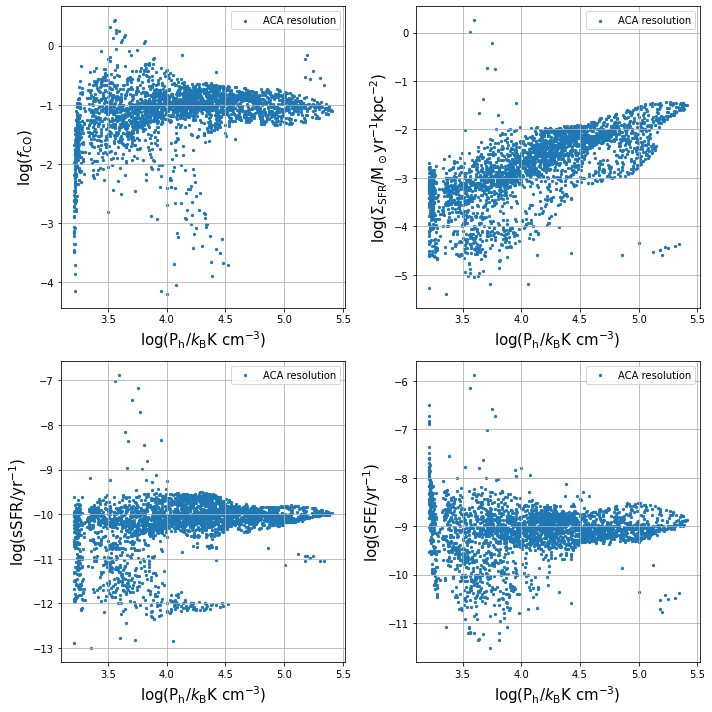

In [44]:
fig, axs = plt.subplots(2,2,figsize=(10,10))#,sharex='col',sharey='row')
for ax,frame,title,label in zip(axs.ravel(),[np.log10(Database['f_CO']),np.log10(Database['S_SFR']),np.log10(Database['sSFR']),np.log10(Database['SFE'])],
                          [r'$f_\mathrm{CO}$',r'$\Sigma_\mathrm{SFR}$','sSFR','SFE'],[r'log($f_\mathrm{CO}$)',r'log($\Sigma_\mathrm{SFR}$/M$_\odot$yr$^{-1}$kpc$^{-2}$)',r'log(sSFR/yr$^{-1}$)',r'log(SFE/yr$^{-1}$)']):
    ax.scatter(np.log10(Database['P_h']),frame,s=5,label='ACA resolution')
    #ax.scatter(np.log10(Ph_hex),frame[1],s=5,label='PyStructure')
    ax.set_ylabel(label,size=15)
    ax.grid(True)
    ax.set_xlabel(r'log(P$_\mathrm{h}$/$k_\mathrm{B}$K cm$^{-3}$)',size=15)
    ax.legend(loc='best')
fig.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(10,10))#,sharex='col',sharey='row')
for ax,frame,title,label in zip(axs.ravel(),[np.log10(Database_SF['f_CO']),np.log10(Database_SF['S_SFR']),np.log10(Database_SF['sSFR']),np.log10(Database_SF['SFE'])],
                          [r'$f_\mathrm{CO}$',r'$\Sigma_\mathrm{SFR}$','sSFR','SFE'],[r'log($f_\mathrm{CO}$)',r'log($\Sigma_\mathrm{SFR}$/M$_\odot$yr$^{-1}$kpc$^{-2}$)',r'log(sSFR/yr$^{-1}$)',r'log(SFE/yr$^{-1}$)']):
    #mask = np.floor(Database['Ha_mask'])==1
    ax.scatter(np.log10(Database_SF['P_h']),frame,s=5)#,label='ACA resolution')
    #ax.scatter(np.log10(Database.loc[~mask,'P_h']),frame[~mask],s=5,label='ACA resolution')
    #ax.scatter(np.log10(Ph_hex),frame[1],s=5,label='PyStructure')
    ax.set_ylabel(label,size=15)
    ax.grid(True)
    ax.set_xlabel(r'log(P$_\mathrm{h}$/$k_\mathrm{B}$K cm$^{-3}$)',size=15)
    #ax.legend(loc='best')
fig.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(10,10))#,sharex='col',sharey='row')
for ax,frame,title,label in zip(axs.ravel(),[np.log10(Database_SF['f_CO']),np.log10(Database_SF['S_SFR']),np.log10(Database_SF['sSFR']),np.log10(Database_SF['SFE'])],
                          [r'$f_\mathrm{CO}$',r'$\Sigma_\mathrm{SFR}$','sSFR','SFE'],[r'log($f_\mathrm{CO}$)',r'log($\Sigma_\mathrm{SFR}$/M$_\odot$yr$^{-1}$kpc$^{-2}$)',r'log(sSFR/yr$^{-1}$)',r'log(SFE/yr$^{-1}$)']):
    #mask = np.floor(Database['Ha_mask'])==1
    ax.hexbin(np.log10(Database_SF['P_h']),frame,mincnt=1)#,label='ACA resolution')
    #ax.scatter(np.log10(Database.loc[~mask,'P_h']),frame[~mask],s=5,label='ACA resolution')
    #ax.scatter(np.log10(Ph_hex),frame[1],s=5,label='PyStructure')
    ax.set_ylabel(label,size=15)
    ax.grid(True)
    ax.set_xlabel(r'log(P$_\mathrm{h}$/$k_\mathrm{B}$K cm$^{-3}$)',size=15)
    #ax.legend(loc='best')
fig.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(10,10))#,sharex='col',sharey='row')
for ax,frame,title,label in zip(axs.ravel(),[np.log10(Database_SF['f_CO']),np.log10(Database_SF['S_SFR']),np.log10(Database_SF['sSFR']),np.log10(Database_SF['SFE'])],
                          [r'$f_\mathrm{CO}$',r'$\Sigma_\mathrm{SFR}$','sSFR','SFE'],[r'log($f_\mathrm{CO}$)',r'log($\Sigma_\mathrm{SFR}$/M$_\odot$yr$^{-1}$kpc$^{-2}$)',r'log(sSFR/yr$^{-1}$)',r'log(SFE/yr$^{-1}$)']):
    #mask = np.floor(Database['Ha_mask'])==1
    for QS in ['SF','MX','nR','cQ','QnR','fR']:
        ax.scatter(np.log10(Database_SF.loc[Database_SF['Final_QS']==QS,'P_h']),frame[Database_SF['Final_QS']==QS],s=5,label=QS)
    #ax.scatter(np.log10(Database.loc[~mask,'P_h']),frame[~mask],s=5,label='ACA resolution')
    #ax.scatter(np.log10(Ph_hex),frame[1],s=5,label='PyStructure')
    ax.set_ylabel(label,size=15)
    ax.grid(True)
    ax.set_xlabel(r'log(P$_\mathrm{h}$/$k_\mathrm{B}$K cm$^{-3}$)',size=15)
    ax.legend(loc='best')
fig.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
#for ax,O3N2,N2,title in zip(axs.ravel(),[alphaCO_O3N2,alphaCO_O3N2_rep],[alphaCO_N2,alphaCO_N2_rep],['Original maps','Reprojected maps']):
ax.hist(Database['R_21'],bins=np.linspace(0,1.5,30),alpha=0.5,label=r'R$_\mathrm{21}$ distribution')
median = np.nanmedian(Database['R_21'])
ax.axvline(np.nanmedian(Database['R_21']),ls='--',c='b',label=f'median: {median:.3}')
ax.set_xlabel(r'R$_\mathrm{21}$',size=12)
ax.set_title(r'R$_\mathrm{21}$ distribution',size=15)
ax.legend(loc='best')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
#for ax,O3N2,N2,title in zip(axs.ravel(),[alphaCO_O3N2,alphaCO_O3N2_rep],[alphaCO_N2,alphaCO_N2_rep],['Original maps','Reprojected maps']):
ax.hist(Database['alphaCO_O3N2'],bins=np.linspace(0.,12,30),alpha=0.5,label='from O3N2')
ax.hist(Database['alphaCO_N2'],bins=np.linspace(0.,12,30),alpha=0.5,label='from N2')
median_O3N2 = np.nanmedian(Database['alphaCO_O3N2'])
median_N2 = np.nanmedian(Database['alphaCO_N2'])
ax.axvline(median_O3N2,ls='--',c='b',label=f'median: {median_O3N2:.3}')
ax.axvline(median_N2,ls='--',c='r',label=f'median: {median_N2:.3}')
ax.axvline(alphaCO_MW,ls='--',c='g',label=f'Milky Way: {alphaCO_MW:.3}')
ax.set_xlabel(r'$\alpha_\mathrm{CO}$ [M$_\odot$K$^{-1}$km$^{-1}$s pc$^{-2}$]',size=12)
ax.legend(loc='best')
plt.show()

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(10,5))#,sharey='row')
#for ax,ZO3N2,ZN2 in zip(axs.ravel(),[Z_O3N2.flatten(),Z_O3N2_rep.flatten()],[Z_N2.flatten(),Z_N2_rep.flatten()]):
axs[0].hexbin(np.log10(Database['Z_O3N2']),np.log10(Database['Z_N2']),bins='log',mincnt=1)
axs[0].plot([-1.,1.],[-1.,1.],c='k',ls='--')
axs[0].set_xlabel(r'log(Z$_\mathrm{O3N2}$/Z$_\odot$)',size=15)
axs[0].set_ylabel(r'log(Z$_\mathrm{N2}$/Z$_\odot$)',size=15)
axs[1].hexbin(Database.loc[(Database['alphaCO_O3N2']<=12)&(Database['alphaCO_N2']<=12),'alphaCO_O3N2'],Database.loc[(Database['alphaCO_O3N2']<=12)&(Database['alphaCO_N2']<=12),'alphaCO_N2'],bins='log',mincnt=1)
axs[1].plot([1.,12.],[1.,12.],c='k',ls='--')
axs[1].set_xlabel(r'$\alpha_\mathrm{CO (O3N2)}$ [M$_\odot$/(K km s$^{-1}$ pc$^2$)]',size=15)
axs[1].set_ylabel(r'$\alpha_\mathrm{CO (N2)}$ [M$_\odot$/(K km s$^{-1}$ pc$^2$)]',size=15)
fig.tight_layout()
plt.show()

In [29]:
    beam_califa = radio_beam.Beam(major=2.5*u.arcsec, minor=2.5*u.arcsec, pa=0*u.deg)
    beam_CO = radio_beam.Beam(major=6*u.arcsec, minor=6*u.arcsec, pa=0*u.deg)

    frames_cube = SpectralCube(data=np.array([M_star,F_NII,F_OIII,F_Ha,F_Hb]),wcs=WCS(califa_hdr))
    frames_cube = frames_cube.with_mask(region)
    frames_cube = frames_cube.with_beam(beam_califa)

    frames_cube_convolved = frames_cube.convolve_to(beam_CO)

    area_factor = pix_area_aca.value/pix_area_califa.value
    reprojected_list = []
    for frame in frames_cube_convolved:
        reprojected, footprint = reproject_exact((frame,WCS(califa_hdr)),target_header)
        reprojected_list.append(reprojected*area_factor)
    reprojected_list = np.array(reprojected_list)

    [M_star_rep,F_NII_rep,F_OIII_rep,F_Ha_rep,F_Hb_rep] = reprojected_list

CGCG429-012
Luminsoty distance at z = 0.01746: 76.125 Mpc
Angular diameter distance at z = 0.01746: 73.534 Mpc
Angular size of ACA spaxel: 1.5 arcsec
Surface area per ACA spaxel: 0.285961 kpc2
Angular size of CALIFA pixel: 0.5 arcsec
Surface area per CALIFA pixel: 0.0317734 kpc2

IC1079
Luminsoty distance at z = 0.02907: 127.81 Mpc
Angular diameter distance at z = 0.02907: 120.69 Mpc
Angular size of ACA spaxel: 1.5 arcsec
Surface area per ACA spaxel: 0.770337 kpc2
Angular size of CALIFA pixel: 0.5 arcsec
Surface area per CALIFA pixel: 0.085593 kpc2

IC1528
Luminsoty distance at z = 0.01252: 54.363 Mpc
Angular diameter distance at z = 0.01252: 53.027 Mpc
Angular size of ACA spaxel: 1.0 arcsec
Surface area per ACA spaxel: 0.0660911 kpc2
Angular size of CALIFA pixel: 0.5 arcsec
Surface area per CALIFA pixel: 0.0165228 kpc2



In [ ]:
    fig, axs = plt.subplots(2,2,figsize=(10,12),subplot_kw={'projection':WCS(califa_hdr)})
    for ax,image,label in zip(axs.ravel(),[M_star,F_OIII,F_Ha,F_Hb],['M_star','F_OIII','F_Ha','F_Hb']):
        im = ax.imshow(image,origin='lower')#,vmin=vmin,vmax=vmax)
        fig.colorbar(im, ax=ax,orientation='horizontal')
        ax.set_title(label+' map',fontsize=15)
        ax.coords['ra'].set_axislabel('RA')
        ax.coords['dec'].set_axislabel('DEC')
    plt.show()
    
    fig, axs = plt.subplots(2,2,figsize=(10,12),subplot_kw={'projection':WCS(aca_hdr)})
    for ax,image,label in zip(axs.ravel(),[M_star_rep,F_OIII_rep,F_Ha_rep,F_Hb_rep],['M_star','F_OIII','F_Ha','F_Hb']):
        im = ax.imshow(image,origin='lower')#,vmin=vmin,vmax=vmax)
        fig.colorbar(im, ax=ax,orientation='horizontal')
        ax.set_title(label+' map',fontsize=15)
        ax.coords['ra'].set_axislabel('RA')
        ax.coords['dec'].set_axislabel('DEC')
    plt.show()

>f8


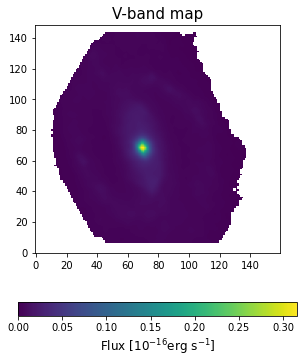

In [78]:
hdu_list = fits.open(califainpath+'UGC12250'+'.Pipe3D.cube.fits.gz')
gaia = hdu_list[7].data
region = hdu_list[8].data
print(gaia.dtype)
    #region = region&(~np.ceil(gaia))
    
v_band = np.where(region,hdu_list[1].data[0],np.nan)
    
fig, ax = plt.subplots(figsize=(5,6))
im = ax.imshow(v_band,origin='lower')
cb = fig.colorbar(im,ax=ax,orientation='horizontal')
cb.set_label(r'Flux [10$^{-16}$erg s$^{-1}$]',size=12)
ax.set_title('V-band map',size=15)
plt.show()
plt.close()
    
hdu_list.close()

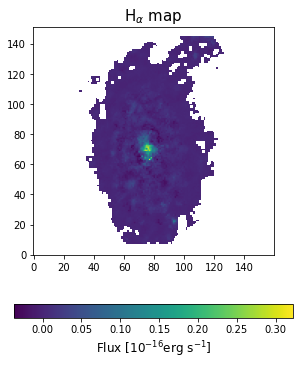

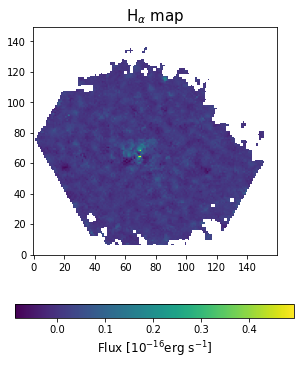

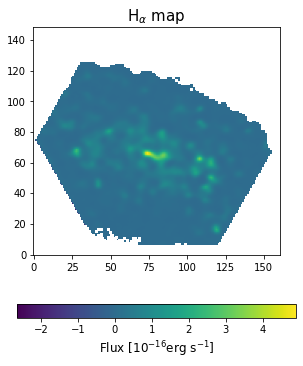

In [24]:
for source in sources[:3]:
    hdu_list = fits.open(califainpath+source+'.Pipe3D.cube.fits.gz')
    gaia = hdu_list[7].data
    region = hdu_list[8].data
    #print(gaia.dtype)
    region = region&np.where(gaia!=0,0,1)
    
    #v_band = np.where(region,hdu_list[1].data[0],np.nan)
    Ha = np.where(region,hdu_list[5].data[45],np.nan)
    
    fig, ax = plt.subplots(figsize=(5,6))
    im = ax.imshow(Ha,origin='lower')
    cb = fig.colorbar(im,ax=ax,orientation='horizontal')
    cb.set_label(r'Flux [10$^{-16}$erg s$^{-1}$]',size=12)
    ax.set_title(r'H$_\alpha$ map',size=15)
    plt.show()
    #plt.savefig(califaoutpath+'/califa_images/'+source+'vband.png')
    plt.close()
    
    hdu_list.close()